In [1]:
import mlrun
import os

# set up project
project_name='mask-detection'
project_dir = os.path.abspath('./')
project = mlrun.new_project(project_name, project_dir)
mlrun.set_environment(project=project.metadata.name)
artifact_path = mlrun.mlconf.artifact_path

# specify paths
code_dir = project_dir # Where our source code files are saved
dataset_path = os.path.join(project_dir, 'dataset') 
model_path = os.path.join(project_dir,'models')
code_dir, dataset_path, model_path

('/home/jovyan/data/mask-detection',
 '/home/jovyan/data/mask-detection/images',
 '/home/jovyan/data/mask-detection/models')

In [2]:
open_archive_function = mlrun.import_function('hub://open_archive')

In [3]:
open_archive_function.run(handler='open_archive', 
                          params={"subdir": './dataset', 'key' :'dataset'}, 
                          inputs={"archive_url": "https://s3.wasabisys.com/iguazio/data/masks_no_masks/archive.zip"},
                          local=True)

> 2021-04-29 20:10:50,249 [info] starting run open-archive-open_archive uid=cb3549c16b4545ce9ce78d3a8dd971ee DB=http://mlrun-api:8080
> 2021-04-29 20:10:50,412 [info] downloading https://s3.wasabisys.com/iguazio/data/masks_no_masks/archive.zip to local tmp


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mask-detection,...8dd971ee,0,Apr 29 20:10:50,completed,open-archive-open_archive,kind=owner=jovyanhost=mlrun-kit-jupyter-5cf6474ff6-bwn2f,archive_url,subdir=./images,,content


to track results use .show() or .logs() or in CLI: 
!mlrun get run cb3549c16b4545ce9ce78d3a8dd971ee --project mask-detection , !mlrun logs cb3549c16b4545ce9ce78d3a8dd971ee --project mask-detection
> 2021-04-29 20:21:40,469 [info] run executed, status=completed


In [5]:
# Set horovod function parameters using MLRun
code_file = os.path.join(code_dir, 'training_code.py')
trainer = mlrun.new_function(name='trainer',
                             kind='mpijob',
                             command=code_file)

trainer.build_config(base_image="mlrun/ml-models", 
                     commands=["apt update; apt install libgl1-mesa-glx", 
                               "pip install opencv-python-headless"])

# set up functions params for testing 
epochs = 1
replicas = 1
batch_size = 32

trainer.spec.replicas = replicas

trainer.apply(mlrun.platforms.auto_mount())

trainer.set_mpi_args(['-x', 'NCCL_DEBUG=INFO'])

In [6]:
trainer.deploy()

> 2021-04-29 20:23:31,774 [info] starting remote build, image: .hedingber/func-mask-detection-trainer:latest
E0429 20:24:31.746187       1 aws_credentials.go:77] while getting AWS credentials NoCredentialProviders: no valid providers in chain. Deprecated.
	For verbose messaging see aws.Config.CredentialsChainVerboseErrors
INFO[0045] Retrieving image manifest mlrun/ml-models:0.6.3-rc5 
INFO[0047] Retrieving image manifest mlrun/ml-models:0.6.3-rc5 
INFO[0051] Built cross stage deps: map[]                
INFO[0051] Retrieving image manifest mlrun/ml-models:0.6.3-rc5 
INFO[0053] Retrieving image manifest mlrun/ml-models:0.6.3-rc5 
INFO[0055] Executing 0 build triggers                   
INFO[0055] Unpacking rootfs as cmd RUN apt update; apt install libgl1-mesa-glx requires it. 
INFO[0265] RUN apt update; apt install libgl1-mesa-glx  
INFO[0265] Taking snapshot of full filesystem...        
INFO[0341] cmd: /bin/sh                                 
INFO[0341] args: [-c apt update; apt insta

False

In [ ]:
trainer.run(params={'epochs'         : epochs,
                    'batch_size'     : batch_size,
                    'imgs'           : dataset_path + '/images',
                    'annot'          : dataset_path + '/annotations',
                    'model_artifacts': model_path})

In [16]:
serving_function_notebook = os.path.join(code_dir, 'serving_code.ipynb')
serving_function = mlrun.code_to_function(name='serving', filename=serving_function_notebook)
serving_function.apply(mlrun.platforms.auto_mount())

In [18]:
# set the functions params for our serving function
function_envs = {
    'IMAGE_HEIGHT': 224,
    'IMAGE_WIDTH': 224,
    'SERVING_MODEL_model': os.path.join(model_path, 'model.h5'),
    'MODEL_CLASS': 'TFModel' #class in tf2_serveing notebook
}
serving_function.set_envs(function_envs)

## Deploy the serving function to the cluster

In [19]:
serving_function.deploy()

> 2021-04-29 16:43:29,262 [info] Starting remote function deploy
2021-04-29 16:43:29  (info) Deploying function
2021-04-29 16:43:29  (info) Building
2021-04-29 16:43:29  (info) Staging files and preparing base images
2021-04-29 16:43:29  (info) Building processor image
2021-04-29 16:43:44  (info) Build complete
> 2021-04-29 16:44:00,293 [info] function deployed, address=192.168.65.3:31280


## Test the deployed function on the cluster

In [20]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import ast
import numpy as np

### Test the deployed function (with URL)

Test image:


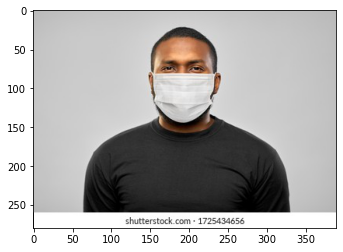

In [21]:
# get and open an image from web
image_url = 'https://image.shutterstock.com/image-photo/health-pandemic-safety-concept-african-260nw-1725434656.jpg'
response = requests.get(image_url)
image = response.content
img = Image.open(BytesIO(image))

print('Test image:')
plt.imshow(img)

In [22]:
# set our serverless serving function address 
serving_address = 'http://nuclio-{}-{}:8080'.format(project.metadata.name, serving_function.metadata.name)

headers = {'Content-type': 'image/jpeg'}
url = serving_address + '/model/predict'

# invoke our function by https request
response = requests.post(url=url, 
                         data=image, 
                         headers=headers)
# decode our request
response.content.decode('utf-8')

'{"Mask probability": 0.7264541387557983}'